<a href="https://colab.research.google.com/github/DanielMelo404/EEG_Markov_model/blob/main/Make_Markov_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyhhmm

In [4]:
import itertools as it
import scipy.spatial.distance as dis
from scipy import signal
import time 
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import resample
from joblib import Parallel, delayed
import pickle
from sklearn.metrics import pairwise_distances

In [5]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases.git
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.utils.git

import gcpds.databases as loaddb

In [6]:
from gcpds.utils import colab
colab.mount()

Mounted at /content/drive


In [7]:
db = loaddb.GIGA_MI_ME()
fs = db.metadata['sampling_rate']
channels = db.metadata['channels']
print(channels)
print(db.metadata['classes'])
print(db.metadata['montage'])
print(fs)

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
['left hand mi', 'right hand mi', 'left hand mm', 'right hand mm']
standard_1005
512


Hacer la lista de sujetos para iterar sobre ella para armar los modelos de markov

In [8]:
import numpy as np
X_ch10 = np.zeros((50,200,512*5))
list_sbjs = []#Lista para guardar tuplas (sujeto, arreglo de trials)
for i in range(50):
    db.load_subject(i+1) 
    print("sbj",i+1)
    if( i+1 != 29):
      run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
      run_aux = run[:,10,512*2:512*7]       #Solo se toman los ultimos 5 segundos porque son los que tienen la informacion para clusterizar
      list_sbjs.append((i+1,run_aux[:,::10]))

sbj 1
sbj 2
sbj 3
sbj 4
sbj 5
sbj 6
sbj 7
sbj 8
sbj 9
sbj 10
sbj 11
sbj 12
sbj 13
sbj 14
sbj 15
sbj 16
sbj 17
sbj 18
sbj 19
sbj 20
sbj 21
sbj 22
sbj 23
sbj 24
sbj 25
sbj 26
sbj 27
sbj 28
sbj 29


sbj 30
sbj 31
sbj 32
sbj 33


sbj 34
sbj 35
sbj 36
sbj 37
sbj 38
sbj 39
sbj 40
sbj 41
sbj 42
sbj 43
sbj 44
sbj 45
sbj 46
sbj 47
sbj 48
sbj 49
sbj 50


In [9]:
import pandas as pd
import seaborn as sns
sbj = 1
db.load_subject(sbj) 
run, class_ = db.get_data(classes=['left hand mi', 'right hand mi'])
run.shape, class_.shape

((200, 64, 3584), (200,))

In [10]:
run_ = run[:,:,::10]
run_.shape

(200, 64, 359)

# Funciones para preparar a la señal para armar los modelos

In [11]:
from sklearn.preprocessing import MinMaxScaler

def pretreatment(x):#Se estandariza la señal  de entrada 
  x= x.reshape(-1,1)
  # x = x[::10]
  minMax = MinMaxScaler()
  x =minMax.fit_transform(x)
  return x

def quantize(x):#Discretizar a la señal en ns+1 cuantos
  ns = 10
  q= 1/(ns)
  y = q * np.round(x/q)
  y = y*10
  return y

##Entrenamiento de HMM con Baum-Welch

In [14]:
import pyhhmm.utils as ut
from pyhhmm.multinomial import MultinomialHMM

def makeMarkovModel(X,str_sbj):#Esta funcion entrena un modelo de markov para una secuencia X
                               #str_sbj es una string para guardar el archivo en el que 
    X = [i.astype(int) for i in X]
    n_states = [1]             # The models trained available on github have 3 states (some 6)
                               # here we change the number of states from 3 to 1 in order to obtain 
                               # the models faster
    
    models_list = []
    AIC_list = []              #Originalmente se escogeria el mejor AIC al entrenar modelos con n_states numero de estados
                               #esta lista los almacena


    criteria = {'AIC': np.zeros_like(n_states), 'BIC': np.zeros_like(n_states)}
    for idx, ns in enumerate(n_states):
      
      trained_hmm = MultinomialHMM(
                    # number of hidden states 
                    n_states=ns,     
                    # number of discrete emissions 
                    n_emissions=1,
                    # length of the observation alphabet 
                    n_features=[11],
                    # type of initialisation to use; can be 'uniform' or 'random'
                    init_type='random'
                    )

      trained_hmm, log_likelihood = trained_hmm.train(
                    X,
                    n_init=1,           # no. of initialisations - we only do it once this time; if multiple initialisations are used, the model with the best log-likelihood will be returned
                    n_iter=100,         # maximum no. of iterations to use
                    conv_thresh=1e-4,   # convergence threshold (in this case if the change in consecutive log-likelihood is < 0.1%)
                    conv_iter=5,        # no. of iterations for which the convergence criteria should hold before stopping
                    plot_log_likelihood=True, # if we want a plot of the log-likelihood evolution over the iterations
                    )

      # compute the number of free parameters of the model
      dof = ut.get_n_fit_scalars(trained_hmm)

      # compute the model order selection criteria
      aic = ut.aic_hmm(log_likelihood, dof)
      criteria['AIC'][idx] = aic
      
      # BIC not used
      bic = 1 
      models_list.append((trained_hmm,aic))
      print('{} states: logL = {:.3f}, AIC = {:.3f}, BIC = {:.3f}'.format(ns, log_likelihood, aic, bic))
      AIC_list.append(aic)
      import os
      # Create folder for saving models in case it doesnt exist
      if not(os.path.exists('modelos')):
        os.mkdir("modelos")

      # Exportar archivo en donde se guarda la lista de modelos que se tienen al momento
      with open('modelos/hmms_'+str_sbj, 'wb') as fp:  
        pickle.dump(models_list, fp)  
                        
      # Dado que n_states tenga mas de un elemento, escoger el modelo con mejor AIC
      if aic == min(AIC_list):
        best_hmm = trained_hmm  
      print(models_list)
    return models_list, best_hmm

from pyhhmm.multinomial import MultinomialHMM
import os

def makeMarkovModelforChannel(sequences,str_sbj):#Rutina para obtener el modelo de markov para un canal
                                                 #sequences: lista de arreglos np de forma (n,1), con estos se enteran
                                                 #str_sbj: es la misma string para el nombre del archivo
  X = []
  for i in range(sequences.shape[0]):
      x = sequences[i,:]
      x = pretreatment(x)
      x = quantize(x)
      x=x.reshape(-1,1)                          #El framework pyhhmm exige esta forma
      X.append(x)
  return makeMarkovModel(X,str_sbj)

Initialisation 1
iter: 0, log_likelihood = -147826.3149433688, delta = nan
iter: 1, log_likelihood = -106896.72524785172, delta = 40929.58969551709
iter: 2, log_likelihood = -106027.71489525151, delta = 869.0103526002058
iter: 3, log_likelihood = -106013.4974366173, delta = 14.21745863421529
iter: 4, log_likelihood = -106013.34389940894, delta = 0.15353720835992135
iter: 5, log_likelihood = -106013.34235138602, delta = 0.0015480229194508865
iter: 6, log_likelihood = -106013.34233589296, delta = 1.5493060345761478e-05
iter: 7, log_likelihood = -106013.34233573801, delta = 1.5494879335165024e-07
iter: 8, log_likelihood = -106013.34233573677, delta = 1.2369127944111824e-09
Converged -> iter: 8, log_likelihood = -106013.34233573677


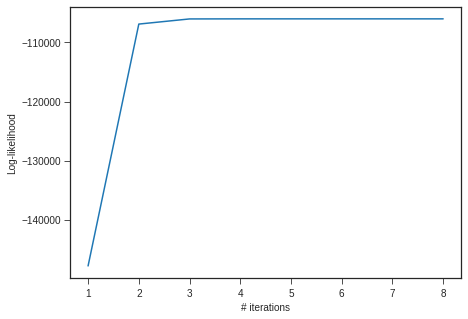

1 states: logL = -106013.342, AIC = 212050.685, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f098188c490>, 212050.68467147354)]
Initialisation 1
iter: 0, log_likelihood = -128478.26946310283, delta = nan
iter: 1, log_likelihood = -110472.09640857184, delta = 18006.173054530984
iter: 2, log_likelihood = -110341.38626463914, delta = 130.7101439327089
iter: 3, log_likelihood = -110339.99346650312, delta = 1.3927981360175181
iter: 4, log_likelihood = -110339.97942908594, delta = 0.01403741717513185
iter: 5, log_likelihood = -110339.97928859961, delta = 0.00014048632874619216
iter: 6, log_likelihood = -110339.97928719479, delta = 1.4048273442313075e-06
iter: 7, log_likelihood = -110339.97928718066, delta = 1.4129909686744213e-08
Converged -> iter: 7, log_likelihood = -110339.97928718066


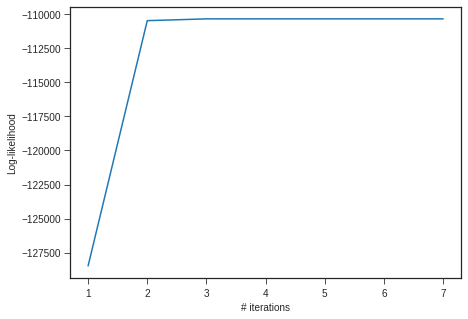

1 states: logL = -110339.979, AIC = 220703.959, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981918b50>, 220703.9585743613)]
Initialisation 1
iter: 0, log_likelihood = -145474.2239747797, delta = nan
iter: 1, log_likelihood = -97213.45751027064, delta = 48260.76646450907
iter: 2, log_likelihood = -96917.6873152398, delta = 295.7701950308401
iter: 3, log_likelihood = -96914.04772504687, delta = 3.6395901929354295
iter: 4, log_likelihood = -96914.01031752683, delta = 0.03740752003795933
iter: 5, log_likelihood = -96914.0099423901, delta = 0.00037513673305511475
iter: 6, log_likelihood = -96914.00993863745, delta = 3.7526478990912437e-06
iter: 7, log_likelihood = -96914.00993859993, delta = 3.7514837458729744e-08
Converged -> iter: 7, log_likelihood = -96914.00993859993


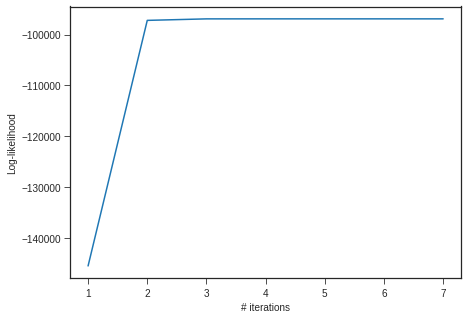

1 states: logL = -96914.010, AIC = 193852.020, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981846790>, 193852.01987719987)]
Initialisation 1
iter: 0, log_likelihood = -190820.4076463122, delta = nan
iter: 1, log_likelihood = -134757.51794357417, delta = 56062.88970273803
iter: 2, log_likelihood = -134146.7944725703, delta = 610.7234710038756
iter: 3, log_likelihood = -134137.287017102, delta = 9.50745546829421
iter: 4, log_likelihood = -134137.18513365329, delta = 0.10188344871858135
iter: 5, log_likelihood = -134137.1841072826, delta = 0.0010263706790283322
iter: 6, log_likelihood = -134137.18409701114, delta = 1.0271469363942742e-05
iter: 7, log_likelihood = -134137.1840969088, delta = 1.023290678858757e-07
Converged -> iter: 7, log_likelihood = -134137.1840969088


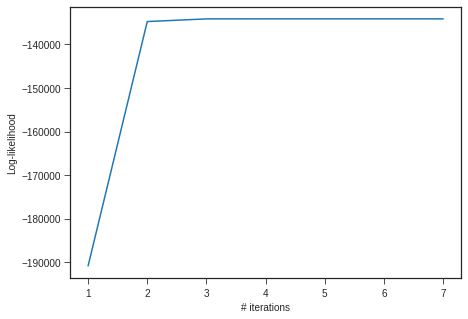

1 states: logL = -134137.184, AIC = 268298.368, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f09813a5f10>, 268298.3681938176)]
Initialisation 1
iter: 0, log_likelihood = -125956.30955375597, delta = nan
iter: 1, log_likelihood = -108769.3295201929, delta = 17186.98003356307
iter: 2, log_likelihood = -108576.07393045466, delta = 193.25558973824081
iter: 3, log_likelihood = -108573.85143039795, delta = 2.222500056712306
iter: 4, log_likelihood = -108573.8288227847, delta = 0.022607613253057934
iter: 5, log_likelihood = -108573.8285963136, delta = 0.0002264710929011926
iter: 6, log_likelihood = -108573.82859404854, delta = 2.265063812956214e-06
iter: 7, log_likelihood = -108573.82859402618, delta = 2.2351741790771484e-08
Converged -> iter: 7, log_likelihood = -108573.82859402618


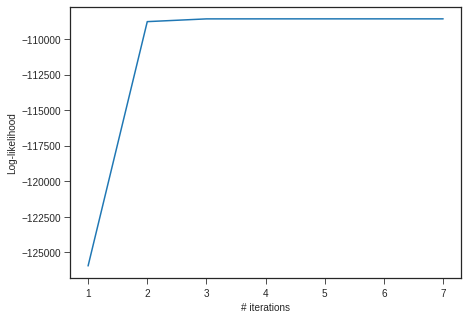

1 states: logL = -108573.829, AIC = 217171.657, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981918f40>, 217171.65718805237)]
Initialisation 1
iter: 0, log_likelihood = -226374.21424648972, delta = nan
iter: 1, log_likelihood = -135813.78928426403, delta = 90560.42496222569
iter: 2, log_likelihood = -134489.5914494567, delta = 1324.1978348073317
iter: 3, log_likelihood = -134466.73259210403, delta = 22.858857352664927
iter: 4, log_likelihood = -134466.48024078028, delta = 0.2523513237538282
iter: 5, log_likelihood = -134466.47768964907, delta = 0.0025511312123853713
iter: 6, log_likelihood = -134466.4776641096, delta = 2.553945523686707e-05
iter: 7, log_likelihood = -134466.47766385428, delta = 2.553279045969248e-07
iter: 8, log_likelihood = -134466.4776638517, delta = 2.5902409106492996e-09
Converged -> iter: 8, log_likelihood = -134466.4776638517


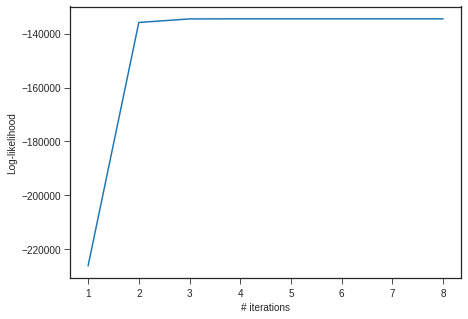

1 states: logL = -134466.478, AIC = 268956.955, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0998e0d2e0>, 268956.9553277034)]
Initialisation 1
iter: 0, log_likelihood = -124238.79531988713, delta = nan
iter: 1, log_likelihood = -106641.63197373551, delta = 17597.163346151618
iter: 2, log_likelihood = -106308.96446437444, delta = 332.66750936106837
iter: 3, log_likelihood = -106304.60854292716, delta = 4.355921447277069
iter: 4, log_likelihood = -106304.56335929541, delta = 0.04518363175156992
iter: 5, log_likelihood = -106304.562905735, delta = 0.00045356040936894715
iter: 6, log_likelihood = -106304.56290119792, delta = 4.537083441391587e-06
iter: 7, log_likelihood = -106304.56290115231, delta = 4.5605702325701714e-08
Converged -> iter: 7, log_likelihood = -106304.56290115231


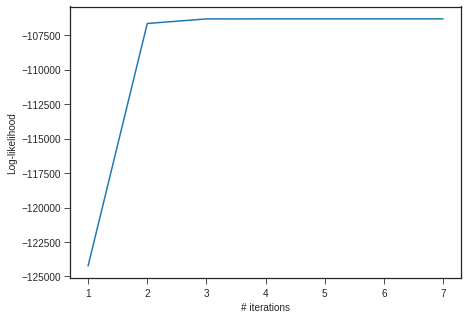

1 states: logL = -106304.563, AIC = 212633.126, BIC = 1.000
[(<pyhhmm.multinomial.MultinomialHMM object at 0x7f0981253a90>, 212633.12580230462)]
Initialisation 1
iter: 0, log_likelihood = -161206.02033156852, delta = nan
iter: 1, log_likelihood = -109973.88736900511, delta = 51232.13296256341
iter: 2, log_likelihood = -109290.25320722738, delta = 683.6341617777362


In [ ]:
lista_hmms = []

# El siguiente ciclo for puede tomar dias en correr debido al entrenamiento de los hmms
for i in range(3,len(list_sbjs)):
  # Entrenar los modelos para todos los sujetos y guardarlos en lista_hmms
  i_ = i+1
  lista_modelos, best_model = makeMarkovModelforChannel(list_sbjs[i][1],'sbj'+str(i+1))
  lista_hmms.append((lista_modelos,best_model))